# Universidad Internacional de La Rioja  

### Máster Universitario en Visual Analytics and Big Data  

---

### **Predicción y Análisis de la Demanda y Suministro de Productos entre la Comunidad Andina y España**  
**Presentado por:** Danilo Andrés Beleño Villafañe  

---

### **Notebook 6: Modelado - Prueba Kmeans**  


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utils.bigquery_handler import BigQueryHandler

In [39]:
bqh = BigQueryHandler('unir-predictiv0-andina-espana')

query = f"""
    SELECT 
        fecha, 
        anio, 
        mes, 
        tipo_movimiento_cod, 
        cod_pais, 
        cod_provincia, 
        cod_comunidad, 
        cod_taric, 
        dolares, 
        kilogramos
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    WHERE nivel_taric = '1' AND tipo_movimiento_cod = 'I'
"""

data = bqh.get_bigquery_data(query)

# Dolares

In [40]:
df =  data.copy()

df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha').reset_index(drop=True)

df['month_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

df_dummies = pd.get_dummies(df, 
                            columns=["tipo_movimiento_cod", "cod_pais", "cod_provincia", "cod_comunidad", "cod_taric"], 
                            drop_first=True)

df_dummies = df_dummies.drop(columns=['fecha', 'kilogramos'])



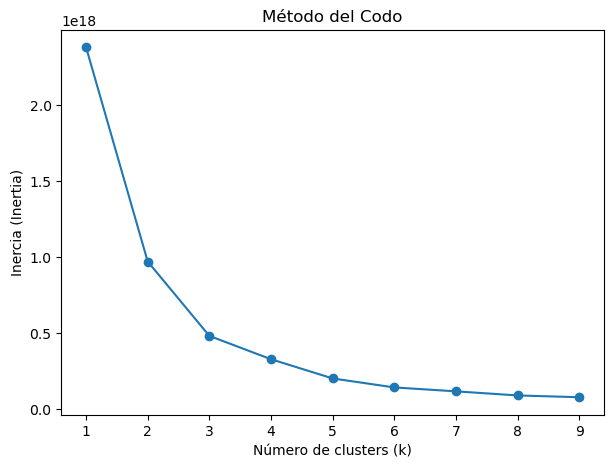

In [41]:
inertias = []
K_range = range(1, 10)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(df_dummies)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Inertia)")
plt.show()

In [42]:
k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, verbose=1)
kmeans.fit(df_dummies)

labels = kmeans.labels_
sil_score = silhouette_score(df_dummies, labels)
print(f"\nSilhouette Score con {k_optimo} clústeres: {sil_score:.2f}")

df['cluster_dlrs'] = labels

Initialization complete
Iteration 0, inertia 3.7313933732721165e+17.
Iteration 1, inertia 3.321270379147864e+17.
Iteration 2, inertia 3.3016847082586624e+17.
Iteration 3, inertia 3.2983763140076045e+17.
Iteration 4, inertia 3.296183678578812e+17.
Iteration 5, inertia 3.293898817213174e+17.
Iteration 6, inertia 3.293031867964072e+17.
Iteration 7, inertia 3.2922831739298874e+17.
Iteration 8, inertia 3.291351808750088e+17.
Iteration 9, inertia 3.288814838003127e+17.
Iteration 10, inertia 3.287387589925078e+17.
Iteration 11, inertia 3.286085862943699e+17.
Iteration 12, inertia 3.285141261688639e+17.
Iteration 13, inertia 3.2845560464503155e+17.
Iteration 14, inertia 3.284051967796048e+17.
Iteration 15, inertia 3.28360122230914e+17.
Iteration 16, inertia 3.283335450216657e+17.
Iteration 17, inertia 3.2831963872597376e+17.
Iteration 18, inertia 3.2830788686410714e+17.
Iteration 19, inertia 3.2829740422816454e+17.
Iteration 20, inertia 3.2829250088182426e+17.
Iteration 21, inertia 3.282877854

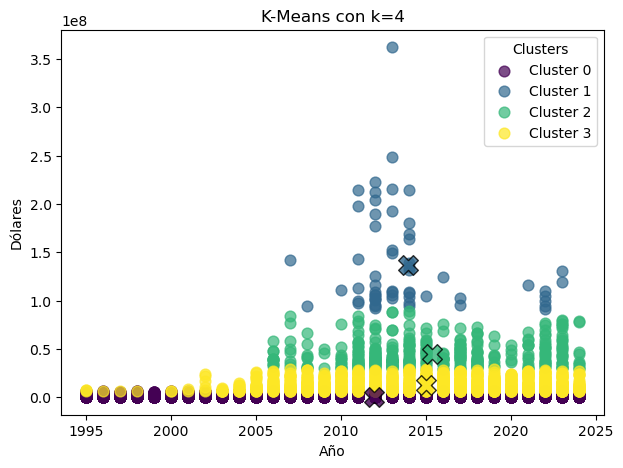

In [43]:
unique_clusters = sorted(df['cluster_dlrs'].unique())

cmap = plt.get_cmap('viridis', len(unique_clusters))

plt.figure(figsize=(7,5))

for i, clust in enumerate(unique_clusters):
    df_cluster = df[df['cluster_dlrs'] == clust]
    plt.scatter(
        df_cluster['anio'],
        df_cluster['dolares'],
        color=cmap(i),
        alpha=0.7,
        s=60,
        label=f"Cluster {clust}"
    )

centroids = df.groupby('cluster_dlrs')[['anio', 'dolares']].mean().reset_index()

for i, row in centroids.iterrows():
    cluster_id = row['cluster_dlrs']
    color_idx = unique_clusters.index(cluster_id)
    plt.scatter(
        row['anio'],
        row['dolares'],
        color=cmap(color_idx),
        marker='X',
        edgecolor='black',
        s=200,
        alpha=0.8
    )

plt.title(f"K-Means con k={k_optimo}")
plt.xlabel('Año')
plt.ylabel('Dólares')
plt.legend(title="Clusters")
plt.show()


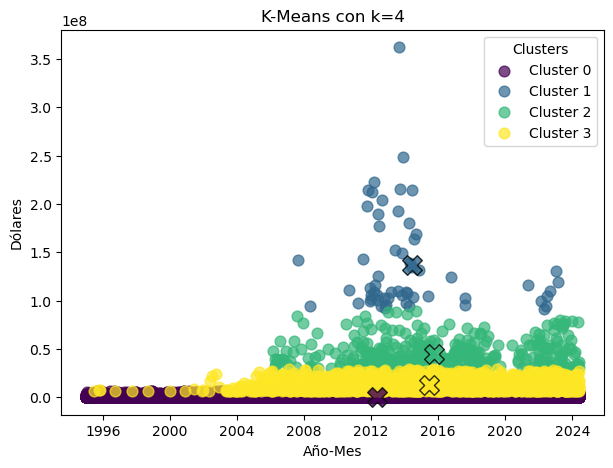

In [44]:
df['anio_mes'] = pd.to_datetime(df['anio'].astype(str) + '-' + df['mes'].astype(str) + '-01')

unique_clusters = sorted(df['cluster_dlrs'].unique())
cmap = plt.get_cmap('viridis', len(unique_clusters))

plt.figure(figsize=(7, 5))

for i, cluster_id in enumerate(unique_clusters):
    df_cluster = df[df['cluster_dlrs'] == cluster_id]
    plt.scatter(
        df_cluster['anio_mes'],
        df_cluster['dolares'],
        color=cmap(i),
        alpha=0.7,
        s=60,
        label=f"Cluster {cluster_id}"
    )

centroids = df.groupby('cluster_dlrs').agg({'anio_mes': 'mean', 'dolares': 'mean'}).reset_index()

for i, row in centroids.iterrows():
    cluster_id = row['cluster_dlrs']
    color_idx = unique_clusters.index(cluster_id)
    plt.scatter(
        row['anio_mes'],
        row['dolares'],
        color=cmap(color_idx),
        s=200,
        alpha=0.8,
        marker='X',
        edgecolor='black',
    )
    
plt.title(f"K-Means con k={k_optimo}")
plt.xlabel('Año-Mes')
plt.ylabel('Dólares')
plt.legend(title="Clusters")
plt.show()


# Kilogramos

In [45]:
df =  data.copy()

df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha').reset_index(drop=True)

df['month_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

df_dummies = pd.get_dummies(df, 
                            columns=["tipo_movimiento_cod", "cod_pais", "cod_provincia", "cod_comunidad", "cod_taric"], 
                            drop_first=True)

df_dummies = df_dummies.drop(columns=['fecha', 'dolares'])



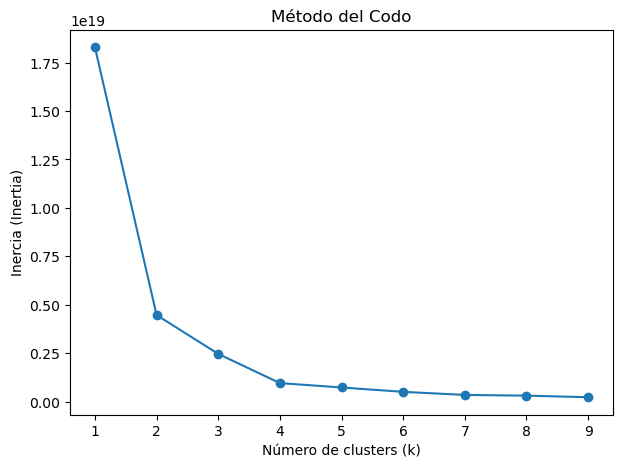

In [46]:
inertias = []
K_range = range(1, 10)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(df_dummies)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Inertia)")
plt.show()

In [47]:
k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, verbose=1)
kmeans.fit(df_dummies)

labels = kmeans.labels_
sil_score = silhouette_score(df_dummies, labels)
print(f"\nSilhouette Score con {k_optimo} clústeres: {sil_score:.2f}")

df['cluster_klgrms'] = labels

Initialization complete
Iteration 0, inertia 1.1779881294198513e+18.
Iteration 1, inertia 9.699581335458574e+17.
Iteration 2, inertia 9.613728198656773e+17.
Iteration 3, inertia 9.573216224731071e+17.
Iteration 4, inertia 9.564199661206301e+17.
Iteration 5, inertia 9.563803773524588e+17.
Iteration 6, inertia 9.563769785895809e+17.
Iteration 7, inertia 9.563752441600735e+17.
Converged at iteration 7: strict convergence.

Silhouette Score con 4 clústeres: 0.99


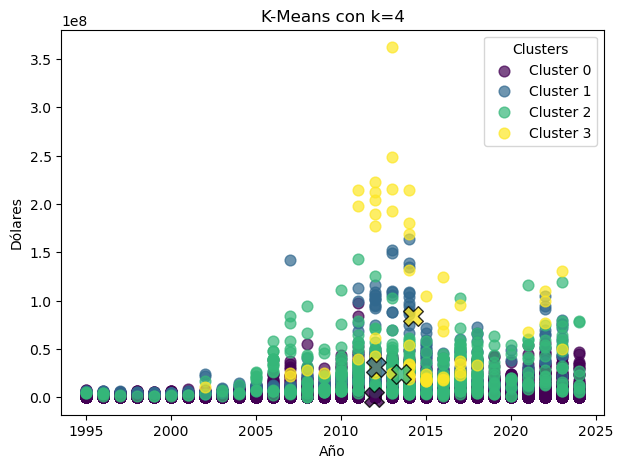

In [48]:
unique_clusters = sorted(df['cluster_klgrms'].unique())

cmap = plt.get_cmap('viridis', len(unique_clusters))

plt.figure(figsize=(7,5))

for i, clust in enumerate(unique_clusters):
    df_cluster = df[df['cluster_klgrms'] == clust]
    plt.scatter(
        df_cluster['anio'],
        df_cluster['dolares'],
        color=cmap(i),
        alpha=0.7,
        s=60,
        label=f"Cluster {clust}"
    )

centroids = df.groupby('cluster_klgrms')[['anio', 'dolares']].mean().reset_index()

for i, row in centroids.iterrows():
    cluster_id = row['cluster_klgrms']
    color_idx = unique_clusters.index(cluster_id)
    plt.scatter(
        row['anio'],
        row['dolares'],
        color=cmap(color_idx),
        marker='X',
        edgecolor='black',
        s=200,
        alpha=0.8
    )

plt.title(f"K-Means con k={k_optimo}")
plt.xlabel('Año')
plt.ylabel('Dólares')
plt.legend(title="Clusters")
plt.show()


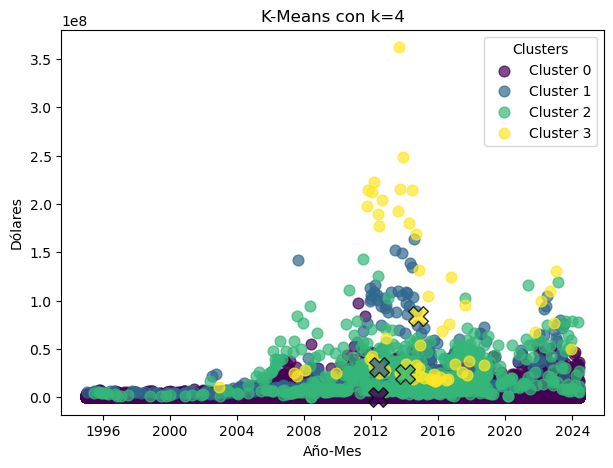

In [49]:
df['anio_mes'] = pd.to_datetime(df['anio'].astype(str) + '-' + df['mes'].astype(str) + '-01')

unique_clusters = sorted(df['cluster_klgrms'].unique())
cmap = plt.get_cmap('viridis', len(unique_clusters))

plt.figure(figsize=(7, 5))

for i, cluster_id in enumerate(unique_clusters):
    df_cluster = df[df['cluster_klgrms'] == cluster_id]
    plt.scatter(
        df_cluster['anio_mes'],
        df_cluster['dolares'],
        color=cmap(i),
        alpha=0.7,
        s=60,
        label=f"Cluster {cluster_id}"
    )

centroids = df.groupby('cluster_klgrms').agg({'anio_mes': 'mean', 'dolares': 'mean'}).reset_index()

for i, row in centroids.iterrows():
    cluster_id = row['cluster_klgrms']
    color_idx = unique_clusters.index(cluster_id)
    plt.scatter(
        row['anio_mes'],
        row['dolares'],
        color=cmap(color_idx),
        s=200,
        alpha=0.8,
        marker='X',
        edgecolor='black',
    )
    
plt.title(f"K-Means con k={k_optimo}")
plt.xlabel('Año-Mes')
plt.ylabel('Dólares')
plt.legend(title="Clusters")
plt.show()


In [50]:
df.head()

,fecha,anio,mes,tipo_movimiento_cod,cod_pais,cod_provincia,cod_comunidad,cod_taric,dolares,kilogramos,month_sin,month_cos,cluster_klgrms,anio_mes
0,1995-01-01,1995,1,I,480,28,15,16,32979.66,25500.0,0.5,0.866025,0,1995-01-01
1,1995-01-01,1995,1,I,480,46,13,06,37287.99,5030.0,0.5,0.866025,0,1995-01-01
2,1995-01-01,1995,1,I,480,46,13,61,8278.41,185.0,0.5,0.866025,0,1995-01-01
3,1995-01-01,1995,1,I,516,08,08,69,473.82,34.0,0.5,0.866025,0,1995-01-01
4,1995-01-01,1995,1,I,480,08,08,61,120085.10,2132.0,0.5,0.866025,0,1995-01-01


In [51]:
df.to_parquet('output/kmeans_output.parquet', index=False)